In [12]:
import argparse
from lib2to3.pgen2 import token
import logging
import os
import random
from dataclasses import dataclass
from itertools import chain
from typing import Optional, Union
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import datasets
import torch
from torch.nn.modules.sparse import Embedding
import torch.nn as nn
from torch.nn.modules.linear import Linear
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import transformers
from train import DataCollatorForMultipleChoice
from accelerate import Accelerator
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    default_data_collator,
    DataCollatorForSeq2Seq,
    AdamW,
    SchedulerType,
    get_scheduler,
    set_seed,
)
from transformers.file_utils import PaddingStrategy
logger = logging.getLogger(__name__)


In [2]:
args = {}
args['dataset_name'] = 'prompts2opts_001_sub.parquet.gzip'
args['model_name_or_path'] = 'bigscience/T0_3B'
args['output_dir'] = '/home/gikok/output'
args['num_train_epochs'] = 1
args['per_device_train_batch_size'] = 2
args['per_device_eval_batch_size'] = 2
args['freeze_encoder'] = True
args['learning_rate'] = 10000
args['parallelize'] = False
args['seed'] = 42
args['pad_to_max_length'] = True
args['input_eos'] = False
args['target_max_length'] = 256
args['max_length'] = 512
args['num_warmup_steps'] = 0
args['debug'] = False
args['lr_scheduler_type'] = 'linear'
args['num_shots'] = None
args['weight_decay'] = 0.01
args['gradient_checkpoint'] = False
args['gradient_accumulation_steps'] = 8
args['max_train_steps'] = None

In [3]:
set_seed(args['seed'])

# Initialize the accelerator. We will let the accelerator handle device placement for us.
accelerator = Accelerator()
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state)

# Setup logging, we only want one process per machine to log things on the screen.
# accelerator.is_local_main_process is only True for one process per machine.
logger.setLevel(
    logging.INFO if accelerator.is_local_main_process else logging.ERROR
)
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()

# Handle the output directory creation
if accelerator.is_main_process:
    os.makedirs(args['output_dir'], exist_ok=True)
accelerator.wait_for_everyone()

# In distributed evaluation, the load_dataset function guarantee that only one local process can concurrently
# download the dataset.
if args['dataset_name'] is not None:
    data_files = {"train": args['dataset_name'], "test": args['dataset_name']}
    raw_train_dataset = load_dataset("data", data_files=data_files, split="train")
    # raw_eval_dataset = load_dataset("data", data_files=data_files, split="test")
else:
    raise ValueError("Please specify `args['dataset_name`.")

# Trim a number of evaluation training
if args['debug']:
    raw_train_dataset = raw_train_dataset.select(
        range(min(100, len(raw_train_dataset)))
    )
    # raw_eval_dataset = raw_eval_dataset.select(
    #     range(min(100, len(raw_eval_dataset)))
    # )

# column_names = raw_eval_dataset.column_names

# Load pretrained model and tokenizer

model = AutoModelForSeq2SeqLM.from_pretrained(args['model_name_or_path']).to('cuda:0')
tokenizer = AutoTokenizer.from_pretrained(args['model_name_or_path'])

# get all item_no and add as tokens
items = pd.read_parquet("data/item_no_6k.parquet.gzip")["item_no"].values.tolist()
tokenizer.add_tokens(items)

# then resize embeddings
model.resize_token_embeddings(len(tokenizer))

# Preprocessing the datasets.
# First we tokenize all the texts.
padding = "max_length" if args['pad_to_max_length'] else False

def tokenize_train(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]

    model_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args['max_length'],
        truncation=True,
        add_special_tokens=args['input_eos'],
    )

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            target_texts,
            padding=padding,
            max_length=args['target_max_length'],
            truncation=True,
            add_special_tokens=False,
        )
        model_inputs["labels"] = [
            [(t if t != tokenizer.pad_token_id else -100) for t in targets]
            for targets in tokenized_targets["input_ids"]
        ]
    return model_inputs

def preprocess_eval(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]
    answer_choices_texts = examples["options"]

    tokenized_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args['max_length'],
        truncation=True,
        add_special_tokens=False,
    )
    tokenized_targets = [
        tokenizer(
            ans_choi,
            padding=True,
            max_length=args['target_max_length'],
            truncation=True,
        )
        for ans_choi in answer_choices_texts
    ]

    features = {
        k: [
            [elem for _ in range(len(tokenized_targets[idx]["input_ids"]))]
            for idx, elem in enumerate(v)
        ]
        for k, v in tokenized_inputs.items()
    }

    features["labels"] = [tokenized_targets[idx]["input_ids"] for idx in range(bs)]
    features["labels_attention_mask"] = [
        tokenized_targets[idx]["attention_mask"] for idx in range(bs)
    ]
    features["targets"] = [
        answer_choices_texts[idx].index(t) for idx, t in enumerate(target_texts)
    ]

    return features

with accelerator.main_process_first():
    # eval_dataset = raw_eval_dataset.map(
    #     preprocess_eval, batched=True, remove_columns=column_names
    # )

    if args['num_shots'] is not None:
        sample_indices = random.sample(
            range(0, len(raw_train_dataset)), k=args['num_shots']
        )
        raw_train_dataset = raw_train_dataset.select(sample_indices)
    train_dataset = raw_train_dataset.map(
        tokenize_train, batched=True
    )
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# Log a few random training:
for index in random.sample(range(len(train_dataset)), 3):
    logger.debug(f"Sample {index} of the training set: {train_dataset[index]}.")
# for index in random.sample(range(len(eval_dataset)), 3):
#     logger.debug(f"Sample {index} of the evaluation set: {eval_dataset[index]}.")

# DataLoaders creation:
train_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if accelerator.use_fp16 else None,
)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=train_collator,
    batch_size=args['per_device_train_batch_size'],
)

# if args['pad_to_max_length']:
#     # If padding was already done ot max length, we use the default data collator that will just convert everything
#     # to tensors.
#     eval_collator = default_data_collator
# else:
    # Otherwise, `DataCollatorWithPadding` will apply dynamic padding for us (by padding to the maximum length of
    # the samples passed). When using mixed precision, we add `pad_to_multiple_of=8` to pad all tensors to multiple
    # of 8s, which will enable the use of Tensor Cores on NVIDIA hardware with compute capability >= 7.5 (Volta).
    # eval_collator = DataCollatorForMultipleChoice(
    #     tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None)
    # )
# eval_dataloader = DataLoader(
#     eval_dataset,
#     collate_fn=eval_collator,
#     batch_size=args['per_device_eval_batch_size'],
# )

# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": args['weight_decay'],
    },
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'])

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(
    len(train_dataloader) / args['gradient_accumulation_steps']
)
if args['max_train_steps'] is None:
    args['max_train_steps'] = args['num_train_epochs'] * num_update_steps_per_epoch
else:
    args['num_train_epochs'] = math.ceil(
        args['max_train_steps'] / num_update_steps_per_epoch
    )

lr_scheduler = get_scheduler(
    name=args['lr_scheduler_type'],
    optimizer=optimizer,
    num_warmup_steps=args['num_warmup_steps'],
    num_training_steps=args['max_train_steps'],
)

if args['parallelize']:
    num_gpus = torch.cuda.device_count()
    assert num_gpus > 1, "You need at least 2 GPUs to use `model.parallelize()`."
    model.parallelize()
    optimizer, train_dataloader = accelerator.prepare(
        optimizer, train_dataloader
    )
else:
    model, optimizer, train_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader
    )

# Metrics
metric = load_metric("accuracy")

total_batch_size = (
    args['per_device_train_batch_size']
    * accelerator.num_processes
    * args['gradient_accumulation_steps']
)
logger.info("***** Running training *****")
logger.info(f"  Num training = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args['num_train_epochs']}")
logger.info(
    f"  Instantaneous batch size per device = {args['per_device_train_batch_size']}"
)
logger.info(
    f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
)
logger.info(f"  Gradient Accumulation steps = {args['gradient_accumulation_steps']}")
logger.info(f"  Total optimization steps = {args['max_train_steps']}")
# Only show the progress bar once on each machine.
progress_bar = tqdm(
    range(args['max_train_steps']), disable=not accelerator.is_local_main_process
)
global_steps = 0

# how often trained model should be saved
r = int(args['max_train_steps'] / 30)
if args['gradient_checkpoint']:
    model.gradient_checkpointing_enable()
model_counter = 0


08/17/2022 13:22:16 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

08/17/2022 13:22:16 - WARNING - datasets.builder - Using custom data configuration data-1847ec1d8d9327ad
08/17/2022 13:22:16 - WARNING - datasets.builder - Reusing dataset parquet (/home/gikok/.cache/huggingface/datasets/parquet/data-1847ec1d8d9327ad/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
loading configuration file https://huggingface.co/bigscience/T0_3B/resolve/main/config.json from cache at /home/gikok/.cache/huggingface/transformers/7b128e6b48089ae556964fea17b39635abd0124e77f8fa30267896af500a4d6d.a54ecffc6881ea8ae0af8a0dca40a7bcd51ccf51d434d2f7d0569844f6fb1c60
Model config T5Config {
  "_name_or_path": "bigscience/T0_3B",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 5120,
  "d_kv": 64,
  "d_model": 2048,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "

In [17]:
embeddings = list(model.named_parameters())[0][1]
lm_head = list(model.named_parameters())[-1][1]

In [41]:
layer=0
n_new = len(items)
new_tensor = list(model.named_parameters())[layer][1].detach().cpu()
for i in range(2048):
    val, bin = np.histogram(new_tensor[:-n_new,i], 10000)
    pdf = val/sum(val)
    cdf = np.cumsum(pdf)
    b = (bin[1:]+bin[:-1])/2
    new_tensor[-n_new:,i] = torch.tensor(np.interp(np.random.random(n_new), cdf, b))
data = list(model.named_parameters())[layer][1].data
data[:,:] = new_tensor


In [5]:
def resample(model, layer, n_new):

    new_tensor = list(model.named_parameters())[layer][1].detach().cpu()
    means = new_tensor[:-n_new,:].mean(axis=0)
    stds = new_tensor[:-n_new,:].std(axis=0)
    for i in range(2048):
        new_tensor[-n_new:,i] = np.random.normal(means[i], stds[i], size = n_new)
        

Parameter containing:
tensor([[  0.1436,   3.8750,   0.5352,  ...,  30.8750,   1.3281, -21.5000],
        [ -4.7812,   7.3125,   3.3438,  ...,  10.3125,  -0.8711,  -1.3047],
        [ -0.4902,   2.3906,  -5.1562,  ...,  -0.5430,   9.8750, -13.5625],
        ...,
        [ -0.3020,  -0.3723,   1.2172,  ...,   1.8101,   1.0143,  -0.7559],
        [ -0.7375,   0.0380,   0.1171,  ...,   1.1145,  -0.9926,   1.0823],
        [  0.4283,   0.9865,   0.6769,  ...,  -1.0338,  -0.2796,  -0.3376]],
       device='cuda:0', requires_grad=True)

In [42]:
og = embeddings[:-n_new,:].detach().cpu()
new = embeddings[-n_new:,:].detach().cpu()

In [43]:
og_vals = np.zeros((2048, 30))
og_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(og[:,i], 30, normed=True)
    og_vals[i] = val
    og_bins[i] = (bin[1:]+bin[:-1])/2

/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


In [44]:
new_vals = np.zeros((2048, 30))
new_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(new[:,i], 30, normed=True)
    new_vals[i] = val
    new_bins[i] = (bin[1:]+bin[:-1])/2

/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


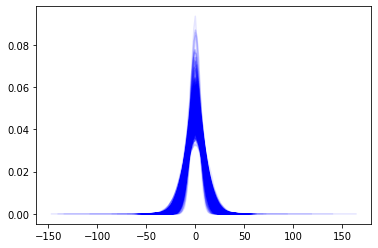

In [45]:
for i in range(2048):
    plt.plot(og_bins[i], og_vals[i], c='blue', alpha=0.1)
plt.show()

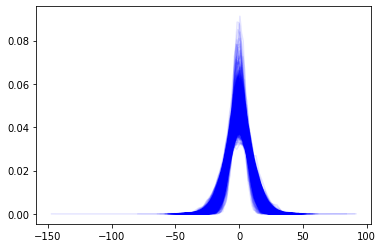

In [46]:
for i in range(2048):
    plt.plot(new_bins[i], new_vals[i], c='blue', alpha=0.1)
plt.show()

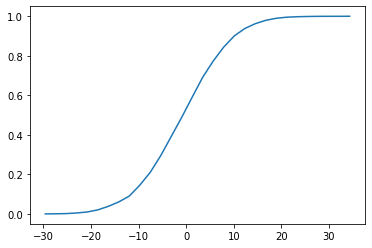

array([-7.90364513, -5.22604294, -2.94816726])

In [7]:
embeddings = list(model.named_parameters())[0][1]
lm_head = list(model.named_parameters())[-1][1]
init_len = len(tokenizer)-len(items)
for epoch in range(1, args['num_train_epochs'] + 1):
    model.train()

    # freeze encoder updates if specified
    if args['freeze_encoder']:
        for name, param in model.named_parameters():
            if name.startswith("encoder") or name.startswith("decoder"):
                param.requires_grad = False
            if name.startswith('shared') or name.startswith("lm_head"):
                grad_mask = torch.ones_like(param)
                grad_mask[:init_len,:] = 0
                h = param.register_hook(lambda grad: grad * grad_mask)
    for step, batch in enumerate(train_dataloader):
        
        outputs = model(**batch)
        loss = outputs.loss
        loss = loss / 8
        accelerator.backward(loss)
        print("emb_grad", (embeddings.grad>0).sum())
        print("lm_grad", (lm_head.grad>0).sum())
        if (
                step % 8 == 0
                or step == len(train_dataloader) - 1
        ):
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            loss = loss.item()

            item_ind = int(global_steps/2) #two batches per item_id
            item_no = items[item_ind]

            # get gradients for embedding matrix and lm_head
            emb_grad = embeddings.grad
            lm_grad = lm_head.grad
            print("INSIDE emb_grad", (embeddings.grad>0).sum())
            print("INSIDE lm_grad", (lm_head.grad>0).sum())
            # embedding_grad_item = torch.norm(emb_grad[init_len+item_ind,:], p=2, dim=-1)
            # embedding_grad_rest = torch.norm(torch.cat((emb_grad[init_len:init_len+item_ind,:], 
            #                                             emb_grad[init_len+item_ind+1:,:])),
            #                                 p=2,
            #                                 dim=-1).mean()
            # lm_grad_item = torch.norm(lm_grad[init_len+item_ind,:], p=2, dim=-1)
            # lm_grad_rest = torch.norm(torch.cat((lm_grad[init_len:init_len+item_ind,:], 
            #                                             lm_grad[init_len+item_ind+1:,:])),
            #                                 p=2,
            #                                 dim=-1).mean()
            # wandb.log({"loss": loss, 'item_no':item_no, 'embedding_grad_item':embedding_grad_item,
            #  'embedding_grad_rest':embedding_grad_rest, 'lm_grad_item':lm_grad_item,
            #  'lm_grad_rest':lm_grad_rest}, step=global_steps)
            # global_steps += 1
        if step>=32:
            break


here3
emb_grad 

  0%|          | 1/6036 [00:01<3:02:18,  1.81s/it]

tensor(2796, device='cuda:0')
lm_grad tensor(6531968, device='cuda:0')
INSIDE emb_grad tensor(0, device='cuda:0')
INSIDE lm_grad tensor(0, device='cuda:0')
here3
emb_grad tensor(3785, device='cuda:0')
lm_grad tensor(2733, device='cuda:0')
here3
emb_grad tensor(3813, device='cuda:0')
lm_grad tensor(2839, device='cuda:0')
here3
emb_grad tensor(3758, device='cuda:0')
lm_grad tensor(7540, device='cuda:0')
here3
emb_grad tensor(3770, device='cuda:0')
lm_grad tensor(8485, device='cuda:0')
here3
emb_grad tensor(6561, device='cuda:0')
lm_grad tensor(8699, device='cuda:0')
here3
emb_grad tensor(6561, device='cuda:0')
lm_grad tensor(10501, device='cuda:0')
here3
emb_grad tensor(6563, device='cuda:0')
lm_grad tensor(11384, device='cuda:0')
here3
emb_grad 

  0%|          | 2/6036 [00:09<8:39:52,  5.17s/it]

tensor(7562, device='cuda:0')
lm_grad tensor(12464, device='cuda:0')
INSIDE emb_grad tensor(0, device='cuda:0')
INSIDE lm_grad tensor(0, device='cuda:0')
here3
emb_grad tensor(1000, device='cuda:0')
lm_grad tensor(1017, device='cuda:0')
here3
emb_grad tensor(997, device='cuda:0')
lm_grad tensor(1050, device='cuda:0')
here3
emb_grad tensor(2874, device='cuda:0')
lm_grad tensor(1942, device='cuda:0')
here3
emb_grad tensor(2846, device='cuda:0')
lm_grad tensor(1960, device='cuda:0')
here3
emb_grad tensor(2856, device='cuda:0')
lm_grad tensor(1952, device='cuda:0')
here3
emb_grad tensor(2830, device='cuda:0')
lm_grad tensor(1941, device='cuda:0')
here3
emb_grad tensor(2831, device='cuda:0')
lm_grad tensor(1951, device='cuda:0')
here3
emb_grad 

  0%|          | 3/6036 [00:16<10:27:12,  6.24s/it]

tensor(4750, device='cuda:0')
lm_grad tensor(2837, device='cuda:0')
INSIDE emb_grad tensor(0, device='cuda:0')
INSIDE lm_grad tensor(0, device='cuda:0')
here3
emb_grad tensor(1029, device='cuda:0')
lm_grad tensor(1016, device='cuda:0')
here3
emb_grad tensor(1023, device='cuda:0')
lm_grad tensor(1887, device='cuda:0')
here3
emb_grad tensor(1055, device='cuda:0')
lm_grad tensor(2017, device='cuda:0')
here3
emb_grad tensor(1041, device='cuda:0')
lm_grad tensor(3112, device='cuda:0')
here3
emb_grad tensor(3858, device='cuda:0')
lm_grad tensor(4035, device='cuda:0')
here3
emb_grad tensor(5728, device='cuda:0')
lm_grad tensor(4122, device='cuda:0')
here3
emb_grad tensor(7619, device='cuda:0')
lm_grad tensor(4146, device='cuda:0')
here3
emb_grad 

  0%|          | 4/6036 [00:24<11:17:44,  6.74s/it]

tensor(11318, device='cuda:0')
lm_grad tensor(5116, device='cuda:0')
INSIDE emb_grad tensor(0, device='cuda:0')
INSIDE lm_grad tensor(0, device='cuda:0')
here3
emb_grad tensor(1056, device='cuda:0')
lm_grad tensor(960, device='cuda:0')
here3
emb_grad tensor(1991, device='cuda:0')
lm_grad tensor(1940, device='cuda:0')
here3
emb_grad tensor(2008, device='cuda:0')
lm_grad tensor(1926, device='cuda:0')
here3
emb_grad tensor(1998, device='cuda:0')
lm_grad tensor(1934, device='cuda:0')
here3
emb_grad tensor(2006, device='cuda:0')
lm_grad tensor(1919, device='cuda:0')
here3
emb_grad tensor(1968, device='cuda:0')
lm_grad tensor(1912, device='cuda:0')
here3
emb_grad tensor(1947, device='cuda:0')
lm_grad tensor(1920, device='cuda:0')
here3
emb_grad 

  0%|          | 5/6036 [00:31<11:45:36,  7.02s/it]

tensor(4721, device='cuda:0')
lm_grad tensor(2833, device='cuda:0')
INSIDE emb_grad tensor(0, device='cuda:0')
INSIDE lm_grad tensor(0, device='cuda:0')


In [8]:
embeddings

Parameter containing:
tensor([[  0.1436,   3.8750,   0.5352,  ...,  30.8750,   1.3281, -21.5000],
        [ -4.7812,   7.3125,   3.3438,  ...,  10.3125,  -0.8711,  -1.3047],
        [ -0.4902,   2.3906,  -5.1562,  ...,  -0.5430,   9.8750, -13.5625],
        ...,
        [ -0.3020,  -0.3723,   1.2172,  ...,   1.8101,   1.0143,  -0.7559],
        [ -0.7375,   0.0380,   0.1171,  ...,   1.1145,  -0.9926,   1.0823],
        [  0.4283,   0.9865,   0.6769,  ...,  -1.0338,  -0.2796,  -0.3376]],
       device='cuda:0', requires_grad=True)

In [9]:
lm_head

Parameter containing:
tensor([[-4.7607e-02, -6.2256e-02, -9.7656e-02,  ...,  2.6245e-02,
          4.2725e-02, -2.9541e-02],
        [-6.7383e-02, -1.2878e-02, -1.5234e-01,  ..., -1.4355e-01,
         -2.8564e-02,  6.4453e-02],
        [-3.1006e-02, -1.5820e-01,  2.6758e-01,  ...,  4.6143e-02,
         -7.4707e-02,  1.6992e-01],
        ...,
        [ 5.1124e+05, -6.2280e+04, -7.8284e+04,  ..., -2.1716e+05,
         -6.6607e+04, -3.2049e+04],
        [ 7.0905e+03, -6.2312e+02, -1.0533e+03,  ..., -2.8763e+03,
         -6.3681e+02, -4.1033e+02],
        [ 1.4768e+03, -1.1156e+02, -2.2923e+02,  ..., -5.1655e+02,
         -1.7873e+02, -6.2893e+01]], device='cuda:0', requires_grad=True)

In [5]:
lm_head.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [14]:
v = torch.ones((emb.shape)).to('cuda:0')
v2 = next(iter(lm._backward_hooks))(v)
v2

TypeError: 'int' object is not callable

In [25]:
list(lm._backward_hooks.keys())[0]

1

In [27]:
emb._backward_hooks[list(emb._backward_hooks.keys())[0]]

<function __main__.<lambda>(grad)>

In [34]:
emb_n = torch.norm(emb, p=2, dim=-1)
lm_n = torch.norm(lm, p=2, dim=-1 )
emb_ = emb.T/emb_n
lm_ = lm.T/lm_n
lm_.shape, emb_.shape

(torch.Size([2048, 32128]), torch.Size([2048, 32128]))

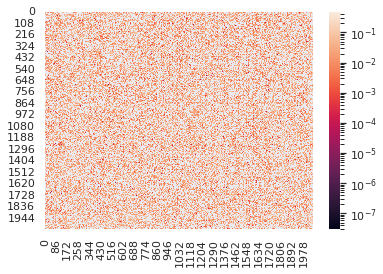

In [38]:
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import torch
with torch.no_grad():
    heat_map = torch.matmul(emb_.cpu(), lm_.T.cpu())
    ax = sns.heatmap(heat_map, norm=LogNorm())

In [116]:
l = tokenizer.encode('what is a cow?', return_tensors='pt').to('cuda:0')
#l = l[0][0]
print(l)
l_e = embedding_module(l)
print(l_e.shape)
l_lm = lm_head(l_e)
print(l_lm.shape)
m = nn.Softmax(dim=-1)
d = m(l_lm).max(axis=-1)[1][0]
print(d)
tokenizer.decode(d, skip_special_tokens=True)

tensor([[ 125,   19,    3,    9, 9321,   58,    1]], device='cuda:0')
torch.Size([1, 7, 2048])
torch.Size([1, 7, 32128])
tensor([  773, 18391, 22154,  9631,  7531, 25900, 11001], device='cuda:0')


'kind Standortalbeitrésboygefordertpermalink'

In [4]:
len(items)

6036

In [5]:
import wandb
wandb.init(project='grad_test', config={'a':'test'})

07/06/2022 11:55:13 - ERROR - wandb.jupyter - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gikok. Use `wandb login --relogin` to force relogin


  0%|          | 9/24144 [04:19<55:59:29,  8.35s/it]

here3
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')


In [15]:
loss

nan

In [14]:
optimizer.step()
lr_scheduler.step()
optimizer.zero_grad()
progress_bar.update(1)
loss

3.676435708999634

In [57]:
a = emb[init_len+item_ind,:]
b = torch.cat((emb[init_len:init_len+item_ind,:], emb[init_len+item_ind+1:,:]))

In [12]:
lm_grad_rest

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [68]:
.mean()

tensor(45.2586, device='cuda:0', grad_fn=<MeanBackward0>)

In [61]:
len(items)

6036

In [12]:
train_collator

DataCollatorForSeq2Seq(tokenizer=PreTrainedTokenizerFast(name_or_path='bigscience/T0_3B', vocab_size=32100, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>

In [25]:
emb[0:10,:].max(axis=-1), lm[0:10,:].max(axis=-1)

(torch.return_types.max(
 values=tensor([ 46.5000,  65.5000,  32.0000,  58.5000,  20.7500,  61.0000,  67.5000,
         112.0000, 122.5000,  86.5000], device='cuda:0', grad_fn=<MaxBackward0>),
 indices=tensor([ 757,  190, 1051,  711,  303,  793,  190,  843,  843,  843],
        device='cuda:0')),
 torch.return_types.max(
 values=tensor([0.2393, 1.4375, 0.5039, 0.3613, 0.6602, 0.2559, 0.2520, 0.3145, 0.2852,
         0.4180], device='cuda:0', grad_fn=<MaxBackward0>),
 indices=tensor([1506, 1035,  161,  351,  431, 1809,  351,  679,  710,  161],
        device='cuda:0')))

In [25]:

model.train()
for name, param in model.named_parameters():
    if name.startswith("encoder") or name.startswith("decoder"):
        param.requires_grad = False
    if name.startswith('shared') or name.startswith("lm_head"):
        t = torch.zeros(param.shape).to('cuda:0')
        t[-len(items):,:] = 1
        param.register_hook(lambda grad: grad*t)
outputs = model(**batch)
loss = outputs.loss
accelerator.backward(loss)
optimizer.step()
lr_scheduler.step()
optimizer.zero_grad()
progress_bar.update(1)
global_steps += 1
loss = loss.item()
if accelerator.is_main_process:
    tqdm.write(f"epoch = {1}, step = {global_steps}, loss = {loss}")


lol
lol


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [60]:
last(model.children())

NameError: name 'last' is not defined

In [32]:
old_values[0][1].grad

In [9]:
t = torch.tensor(np.zeros((new_values[0][1].shape[0], new_values[0][1].shape[1])))

In [10]:
t[-len(items):,:] = 1

In [62]:
hook.remove()

In [28]:
l = 0
for mod in model.modules():
    l +=1
    if isinstance(mod, Embedding):
        if mod.num_embeddings == 38136:
            print(l,mod)
            print(type(mod))
            print(mod.num_embeddings)
            print("****************")

2 Embedding(38136, 2048)
<class 'torch.nn.modules.sparse.Embedding'>
38136
****************


In [38]:
l = 0
for mod in model.modules():
    print(mod)
    print("**************")

T5ForConditionalGeneration(
  (shared): Embedding(38136, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(38136, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedGeluDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
      

torch.Size([2048, 2048])

T5Attention(
  (q): Linear(in_features=2048, out_features=2048, bias=False)
  (k): Linear(in_features=2048, out_features=2048, bias=False)
  (v): Linear(in_features=2048, out_features=2048, bias=False)
  (o): Linear(in_features=2048, out_features=2048, bias=False)
  (relative_attention_bias): Embedding(32, 32)
)